<a href="https://colab.research.google.com/github/Loop3D/2022_iamg_workshop/blob/main/loopui/ui-5-connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dissimilarity based on connectivity analysis

Connectivity aims at identifying preferential flow path and can be measured as the probability of two voxels being connected. In a voxet, property field values can be classified in distinct categories. Two voxels  are said connected if there exists a path defined by adjacent voxels of the same class bewteen them. 

Due to the definition of connectivity, related metrics or indicators can be computed from binary voxets. For discrete property fields, it implies as many indicators as categories. For continuous property fields, it requires a form of discretization. In addition, connectivity can be estimated as a global measure or as a function of a distance between voxels, similarly to what can be done to compute empirical semi-variograms. In the following notebook, we illustrate global or lag-dependent uncertainty indicators for 2D and 3D, discrete and continuous property fields.

One can note that the number of voxel pairs to be considered is in the order of $n^2$, where $n$ is the voxet size. To keep computing time reasonable, we randomly sub-sample among the pairs of voxels.

See the papers of [Renard and Allard (2013)](https://www.sciencedirect.com/science/article/pii/S0309170811002223?casa_token=woQblJzETg8AAAAA:EP2T6n5KGFh1CSnhFYwUGDSNcJ_qK_MyM7df0f5aNcqS_hPllijJTHBY8J2vFVRqlQELvqJRTQ) or [Meerschman et al. (2013)](https://www.sciencedirect.com/science/article/pii/S0098300412003299?casa_token=eM_liiR_q98AAAAA:t4ybsl4q_vOFWAsSVfn3aShtHohXJb9mGJaDf1frwlb3fp06EdlqGPUBoTX4zsEosxVvejebAQ) for more details.

### References
Meerschman, E., Pirot, G., Mariethoz, G., Straubhaar, J., Van Meirvenne, M., & Renard, P. (2013). A practical guide to performing multiple-point statistical simulations with the Direct Sampling algorithm. Computers & Geosciences, 52, 307-324. https://doi.org/10.1016/j.cageo.2012.09.019

Renard, P., & Allard, D. (2013). Connectivity metrics for subsurface flow and transport. Advances in Water Resources, 51, 168-196. https://doi.org/10.1016/j.advwatres.2011.12.001


In [1]:
!pip install loopui

In [2]:
# import modules
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn import manifold
import pickle
from loopui import dist_lpnorm_percentile_global_connectivity, dist_lpnorm_categorical_lag_connectivity, dist_lpnorm_percentile_lag_connectivity 
from loopui import mxdist_lpnorm_categorical_lag_connectivity,mxdist_lpnorm_percentile_global_connectivity

picklefilenameconnectivity = "synthetic-case-connectivity.pickle"
picklefilenamedata = "synthetic-case-data.pickle"

# plotting parameters
slice_ix=0
slice_iy=0
slice_iz=7
aspectratio = 1 # !! in pixels !!
sample_num1 = 0
sample_num2 = 10

# 2PS based dissimilarity parameters
seed = 65432
max3Dnbsamples = int(0.6E3)
max2Dnbsamples = int(0.3E3)
pnorm = 2 
npctiles=20
nblags=10


In [3]:
from urllib.request import urlopen

# Source
url = "https://cloudstor.aarnet.edu.au/plus/s/8QXx85YG7Kgf8Nl/download?path=%2f"
# Download from URL
with urlopen(url) as file:
    content = file.read()
# Save to file
with open(picklefilenamedata, 'wb') as download:
    download.write(content)

# import data
with open(picklefilenamedata, 'rb') as f:
    [lithocode_100,lithocode_50A,lithocode_50B,scalarfield_100,scalarfield_50A,
     scalarfield_50B,nx,ny,nz,nbsamples,clblab,clblabsf] = pickle.load(f)

In [4]:
# Concatenate data together
yyy,zzz,xxx=np.meshgrid(np.arange(1,ny+1),np.flip(np.arange(1,nz+1)),np.arange(1,nx+1))
xx=xxx[slice_iz,:,:]
yy=yyy[slice_iz,:,:]
zz=zzz[slice_iz,:,:]
maxh3D = np.sqrt(nx**2+ny**2+nz**2)/3
maxh2D = np.sqrt(nx**2+ny**2)/3

lithocode_all = np.reshape(np.stack((lithocode_100,lithocode_50A,lithocode_50B),axis=4),(nz,ny,nx,nbsamples*3),order='F')
scalarfield_all = np.reshape(np.stack((scalarfield_100,scalarfield_50A,scalarfield_50B),axis=4),(nz,ny,nx,nbsamples*3),order='F')

# load classes
categval = np.unique(lithocode_all)

## Indicator connectivity
For each class, we compute the connectivity as the probability that 2 points of the same class are connected, as a function of lag distance.

The maximum lag distance is indicated as an input parameter 'maxh2D' or 'maxh3D'. The number of lags $N$ is given by the parameter 'nblags'. The lag width $\delta$ is obtained by dividing the maximum lag distance by the number of lags. 

For a binary (0 or 1) voxet with $(v_j,v_k)$ denoting the pairs of voxets of class 1, the connectivity $\Gamma$ is defined as a function of the lag distance as:
$$
\Gamma(h_i) = {{\sum\limits_{(j,k)} \mathbb{1}^{connected}(v_j,v_k) }\over{\sum\limits_{(j,k)} 1}} \text{, where }1\leq i \leq N \text{, }h_i = \delta \times (i-0.5) \text{ and the distance between voxets } v_j \text{ and } v_k \text{ is bounded by } h_i \pm 0.5\delta \text{.}
$$


Given two indicator connectivity functions $\Gamma_1$ and $\Gamma_2$, we propose to use the following distance: <br>
$ ||\Gamma_1(c) - \Gamma_2(c) ||_p = \left( {{{1}\over{n}}} \sum \limits_{1\leq i \leq n} |\Gamma_1(h_i) - \Gamma_2(h_i)|^p \right)^{{{1}\over{p}}}$, where $p=2$ in the following illustrations and $c$ denotes the class index.

Then, a connectivity based distance between two discrete voxets can be computed as:<br>
$ ||\Gamma_1 - \Gamma_2 ||_p = \left({{1}\over{ \sum \limits_c 1}} \sum \limits_c \left(||\Gamma_1(c) - \Gamma_2(c) ||_p \right)^p \right)^{{{1}\over{p}}}$


### 3D case

23-Aug-2022 (12:23:19) - COMPUTING INDICATOR CONNECTIVITY LITHOCODE 3D START
indicator 0
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.0


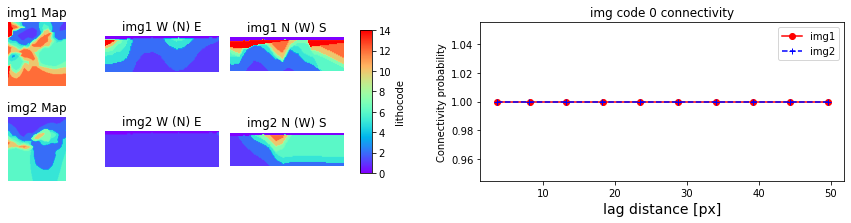

indicator 1
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point


C:\Users\00102908\Anaconda3\envs\loopy\lib\site-packages\loopui\main.py:848: RuntimeWarning: overflow encountered in long_scalars
  elif img1cnt*img2cnt==0:


computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.007468481563483933


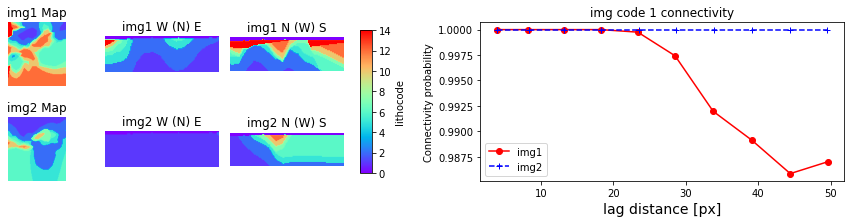

indicator 2
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point


C:\Users\00102908\Anaconda3\envs\loopy\lib\site-packages\loopui\main.py:848: RuntimeWarning: overflow encountered in long_scalars
  elif img1cnt*img2cnt==0:


computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.0


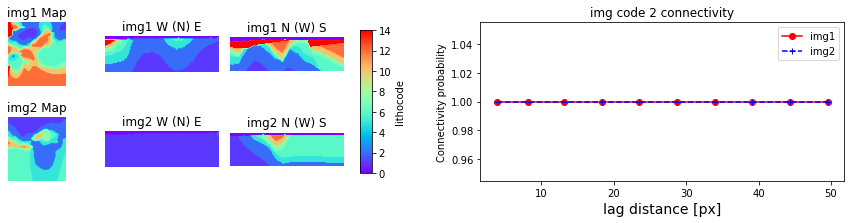

indicator 3
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.06281101227618084


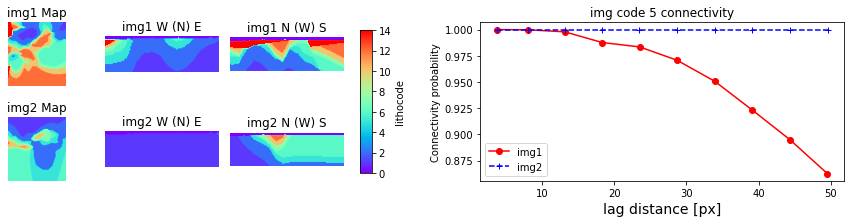

indicator 4
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point


C:\Users\00102908\Anaconda3\envs\loopy\lib\site-packages\loopui\main.py:848: RuntimeWarning: overflow encountered in long_scalars
  elif img1cnt*img2cnt==0:


computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.03143831319638657


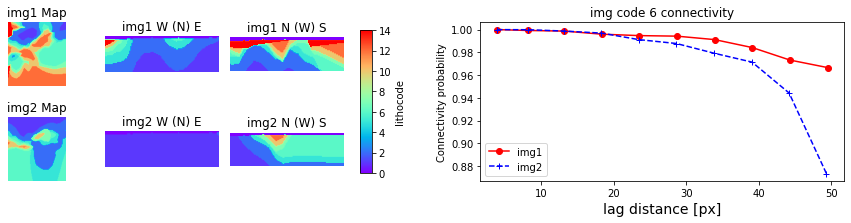

indicator 5
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.5611997022630764


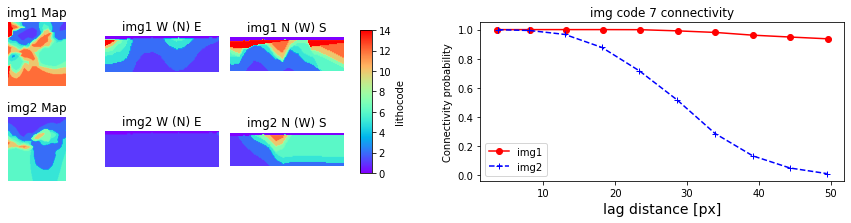

indicator 6
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.5560178820963656


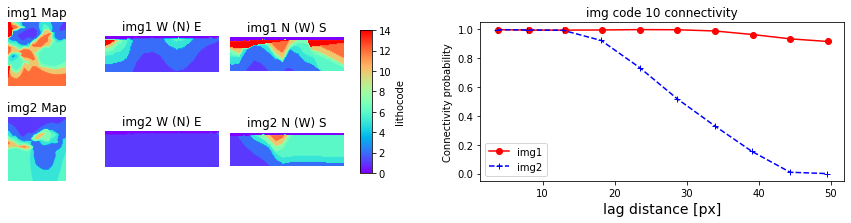

indicator 7
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.440016337584107


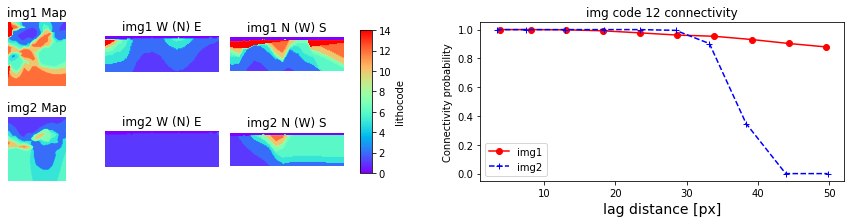

indicator 8
distance contribution: 0.1111111111111111


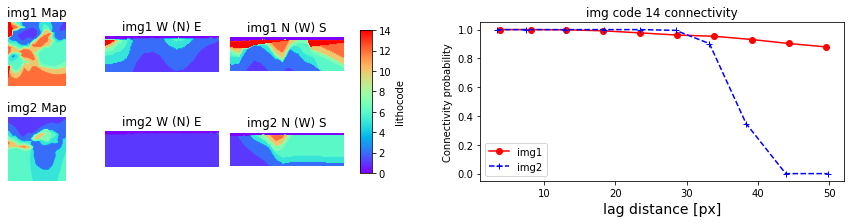

23-Aug-2022 (12:24:11) - COMPUTING INDICATOR CONNECTIVITY LITHOCODE 3D END


In [5]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING INDICATOR CONNECTIVITY LITHOCODE 3D START")
img1=lithocode_all[:,:,:,sample_num1].astype(int)
img2=lithocode_all[:,:,:,sample_num2].astype(int)
clblab='lithocode'
dist_lpnorm_categorical_lag_connectivity(img1,img2,xxx,yyy,zzz,nblags,maxh3D,max3Dnbsamples,pnorm,clblab=clblab,plot=True,verb=True,slice_iz=slice_iz)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING INDICATOR CONNECTIVITY LITHOCODE 3D END")

### 2D case
Same definition

23-Aug-2022 (12:24:11) - COMPUTING INDICATOR CONNECTIVITY LITHOCODE 2D START
indicator 0
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.4714045207910317


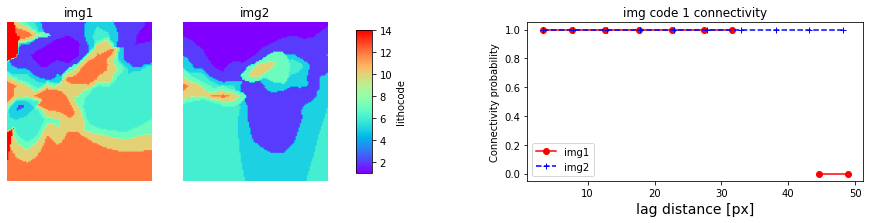

indicator 1
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.36541665637297005


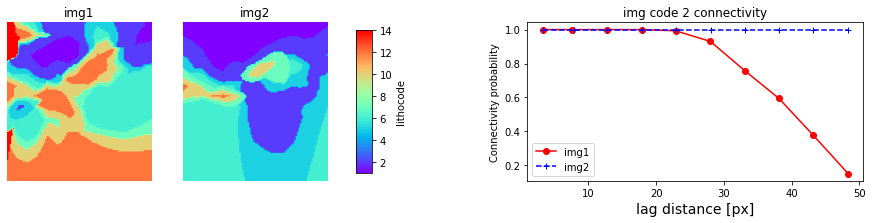

indicator 2
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.5951715899928548


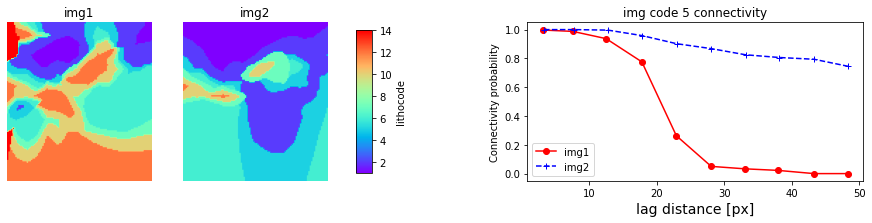

indicator 3
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.20515900845595741


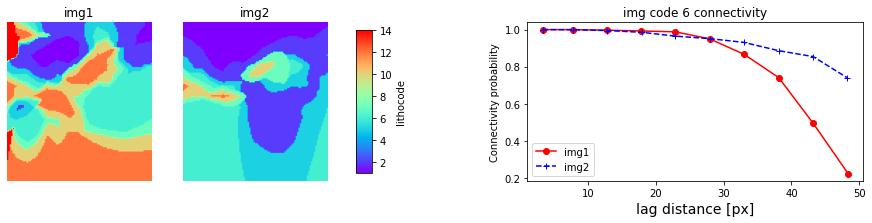

indicator 4
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.2192148359588265


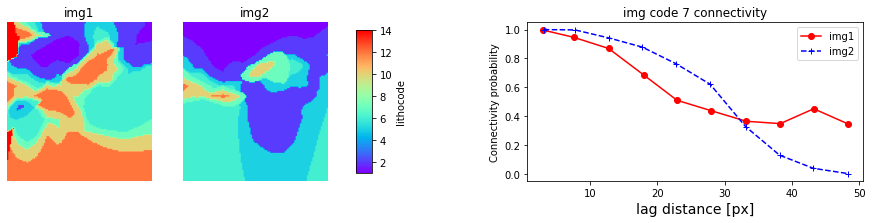

indicator 5
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.5770656958977833


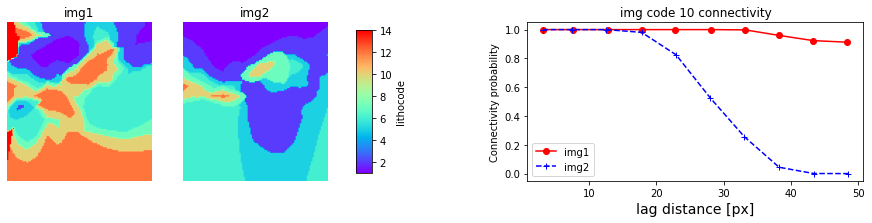

indicator 6
img1 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
img2 compute indicator_lag_connectivity
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.6328917620946858


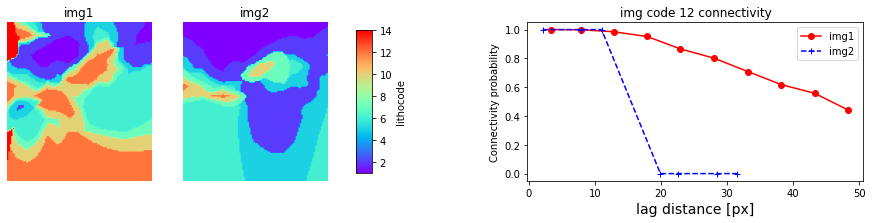

indicator 7
distance contribution: 0.125


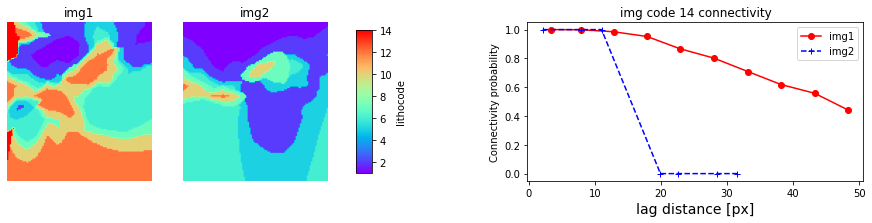

23-Aug-2022 (12:24:21) - COMPUTING INDICATOR CONNECTIVITY LITHOCODE 2D END


In [6]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING INDICATOR CONNECTIVITY LITHOCODE 2D START")
img1=np.reshape(lithocode_all[slice_iz,:,:,sample_num1].astype(int),(ny,nx))
img2=np.reshape(lithocode_all[slice_iz,:,:,sample_num2].astype(int),(ny,nx))
clblab='lithocode'
dist_lpnorm_categorical_lag_connectivity(img1,img2,xx,yy,zz,nblags,maxh2D,max2Dnbsamples,pnorm,clblab=clblab,plot=True,verb=True)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING INDICATOR CONNECTIVITY LITHOCODE 2D END")

## Continuous detailed Connectivity

Continuous property fields can be discretized into regular bins or along regular percentiles of their empirical distribution. In the first case, one could then apply indicator connectivity as defined above to each category. Here we chose the second approach. Each retained percentile defines a threshold that delineates the property field in two subsets of points, of higher (h) and lower (l) values respectively. For each subset of points, the indicator connectivity can be estimated as a function  of lag distance, as defined above. Then, for a given continuous property field, the connectivity can be represented by two maps $\Gamma^{l,k}(h_i)$ and $\Gamma^{h,k}(h_i)$ for the subsets of lower and higher values respectively, where $k$ and $i$ denotes the percentile and lag indices respectively. 

In that case, a distance between the connectivity $\Gamma_1$ and $\Gamma_2$ of two voxets can be defined as:

$ ||\Gamma_1 - \Gamma_2 ||_p = \left( {{1}\over{2 \sum \limits_{i,k} 1}} \sum \limits_{i,k} |\Gamma_1^{l,k}(h_i) - \Gamma_2^{l,k}(h_i)|^p + {{1}\over{2 \sum \limits_{i,k} 1}} \sum \limits_{i,k} |\Gamma_1^{h,k}(h_i) - \Gamma_2^{h,k}(h_i)|^p \right)^{{{1}\over{p}}}$, where $p$ is the degree of the norm.

### 2D case

23-Aug-2022 (12:24:21) - COMPUTING percentile lag continuous CONNECTIVITY 2D START
5.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.0031250000000000006
10.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
10.0th percentile connectivity - lower img2
computing 

computing connexion probability per lag
60.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
60.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.0003579431716468871
65.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
65.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
65.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
65.0th percentile connectivity - upper img2
computing distance and connexion for each sampled

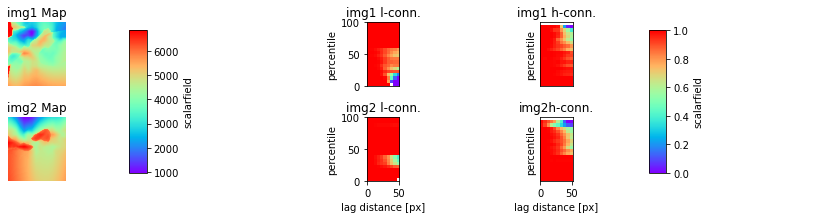

23-Aug-2022 (12:25:28) - COMPUTING percentile lag continuous CONNECTIVITY 2D END


In [7]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING percentile lag continuous CONNECTIVITY 2D START")
img1=np.reshape(scalarfield_all[slice_iz,:,:,sample_num1],(ny,nx))
img2=np.reshape(scalarfield_all[slice_iz,:,:,sample_num2],(ny,nx))
clblab='scalarfield'
dist_lpnorm_percentile_lag_connectivity(img1,img2,xx,yy,zz,npctiles,nblags,maxh2D,max2Dnbsamples,pnorm,clblab=clblab,plot=True,verb=True)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING percentile lag continuous CONNECTIVITY 2D END")


### 3D case

23-Aug-2022 (12:25:28) - COMPUTING percentile lag continuous CONNECTIVITY 3D START
5.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
5.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.00626321804780961
10.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point


C:\Users\00102908\Anaconda3\envs\loopy\lib\site-packages\loopui\main.py:949: RuntimeWarning: overflow encountered in long_scalars
  elif img1cnth*img2cnth==0:


computing connexion probability per lag
10.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
10.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
10.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 0.004954310576609575
15.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
15.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
15.0th percentile connectivity - upper img1
computing distance and connexion for each sampled 

C:\Users\00102908\Anaconda3\envs\loopy\lib\site-packages\loopui\main.py:943: RuntimeWarning: overflow encountered in long_scalars
  elif img1cntl*img2cntl==0:


computing connexion probability per lag
20.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
20.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
20.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 1.1431521606138296e-05
25.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
25.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
25.0th percentile connectivity - upper img1
computing distance and connexion for each sample

computing connexion probability per lag
80.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
80.0th percentile connectivity - upper img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
80.0th percentile connectivity - upper img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
distance contribution: 1.2441507467915776e-07
85.0th percentile connectivity - lower img1
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
85.0th percentile connectivity - lower img2
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
85.0th percentile connectivity - upper img1
computing distance and connexion for each sample

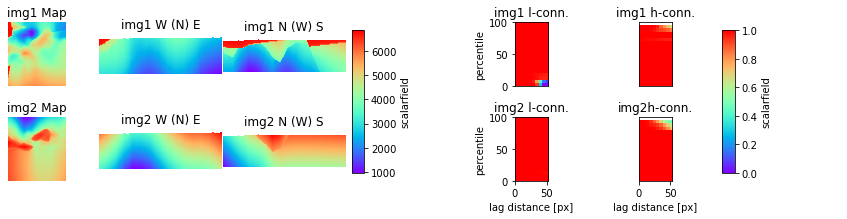

23-Aug-2022 (12:30:06) - COMPUTING percentile lag continuous CONNECTIVITY 3D END


In [8]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING percentile lag continuous CONNECTIVITY 3D START")
img1=scalarfield_all[:,:,:,sample_num1]#.astype(int)
img2=scalarfield_all[:,:,:,sample_num2]#.astype(int)
clblab='scalarfield'
dist_lpnorm_percentile_lag_connectivity(img1,img2,xxx,yyy,zzz,npctiles,nblags,maxh3D,max3Dnbsamples,pnorm,clblab=clblab,plot=True,verb=True,slice_iz=slice_iz)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING percentile lag continuous CONNECTIVITY 3D END")

## Continuous Global Connectivity

Another possibility for continuous property fields is to compute their global connectivity as a function of percentile threshold along their experimental cumulative denisy function. It can be seen as the integration of the detailed connectivity introduced above integrated along the lag distance and it produces one connectivity function for lower values and another one for higher values, with respect to the percentile threshold.

For a binary voxet, the global connectivity can be computed as:

$\Gamma(k,l) = \sum \limits_i p_i^2$, where $i$ denotes the labelled objects and $p_i$ is their proportion in their category ($\sum \limits_i p_i = 1$), $k$ denoting the percentile threshold index and $l$ the lower or higher set of values.

Then, given two global connectivity functions $\Gamma_1$ and $\Gamma_2$, we propose to use the following distance:

$ ||\Gamma_1 - \Gamma_2 ||_p = \left( {{1}\over{ \sum \limits_{k,l} 1}} \sum \limits_{k,l} |\Gamma_1(k,l) - \Gamma_2(k,l)|^p \right)^{{{1}\over{p}}}$, where $p=2$ in the following illustrations.


23-Aug-2022 (12:30:06) - COMPUTING Global CONTINUOUS CONNECTIVITY 2D
global connectivity img1
Computing global percentile connectivity
5.0th percentile - global connectivity
10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th percentile - global connectivity
30.0th percentile - global connectivity
35.0th percentile - global connectivity
40.0th percentile - global connectivity
45.0th percentile - global connectivity
50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th percentile - global connectivity
70.0th percentile - global connectivity
75.0th percentile - global connectivity
80.0th percentile - global connectivity
85.0th percentile - global connectivity
90.0th percentile - global connectivity
95.0th percentile - global connectivity
100.0th percentile - global connectivity
global connectivity img2
Computing global percentile connectivity

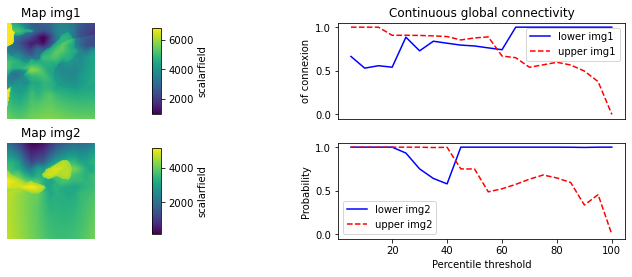

23-Aug-2022 (12:30:08) - COMPUTING Global CONTINUOUS CONNECTIVITY 2D
23-Aug-2022 (12:30:08) - COMPUTING Global CONTINUOUS CONNECTIVITY 3D
global connectivity img1
Computing global percentile connectivity
5.0th percentile - global connectivity
10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th percentile - global connectivity
30.0th percentile - global connectivity
35.0th percentile - global connectivity
40.0th percentile - global connectivity
45.0th percentile - global connectivity
50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th percentile - global connectivity
70.0th percentile - global connectivity
75.0th percentile - global connectivity
80.0th percentile - global connectivity
85.0th percentile - global connectivity
90.0th percentile - global connectivity
95.0th percentile - global connectivity
100.0th percentile - global connectiv

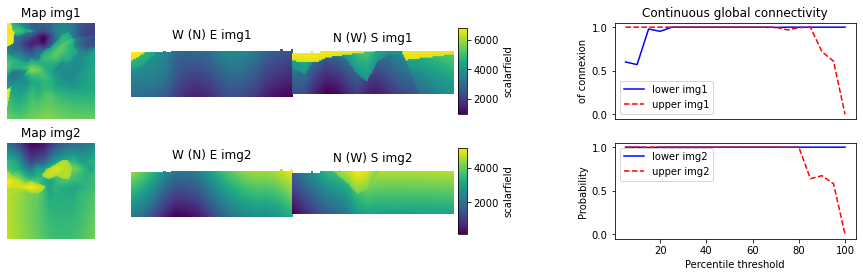

23-Aug-2022 (12:30:13) - COMPUTING Global CONTINUOUS CONNECTIVITY 3D


In [9]:
# 2D case
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING Global CONTINUOUS CONNECTIVITY 2D")
img1=np.reshape(scalarfield_all[slice_iz,:,:,sample_num1],(ny,nx))
img2=np.reshape(scalarfield_all[slice_iz,:,:,sample_num2],(ny,nx))
clblab='scalarfield'
dist_lpnorm_percentile_global_connectivity(img1,img2,npctiles,pnorm,clblab=clblab,plot=True,verb=True)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING Global CONTINUOUS CONNECTIVITY 2D")

# 3D case
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING Global CONTINUOUS CONNECTIVITY 3D")
img1=scalarfield_all[:,:,:,sample_num1]#.astype(int)
img2=scalarfield_all[:,:,:,sample_num2]#.astype(int)
clblab="scalarfield"
dist_lpnorm_percentile_global_connectivity(img1,img2,npctiles,pnorm,clblab=clblab,plot=True,verb=True,slice_iz=slice_iz)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING Global CONTINUOUS CONNECTIVITY 3D")


## Compute for all pair of realizations<span style='color:red'>\*</span>
<span style='color:red'>**\*WARNING: IT COULD TAKE AROUND 8 MINUTES. PRECOMPUTED RESULTS ALREADY AVAILABLE IN THE PICKLE FOLDER** </span>

In [10]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING CONNECTIVITY BASED DIST ALL START")
dist_cty_lc = np.zeros((nbsamples,nbsamples))
dist_cty_sf = np.zeros((nbsamples,nbsamples))
dist_cty_lc = mxdist_lpnorm_categorical_lag_connectivity(lithocode_all,categval,xxx,yyy,zzz,nblags,maxh3D,max3Dnbsamples,pnorm,verb=True)
dist_cty_sf = mxdist_lpnorm_percentile_global_connectivity(scalarfield_all,npctiles,pnorm,verb=True)        
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING CONNECTIVITY BASED DIST ALL END")

23-Aug-2022 (12:30:13) - COMPUTING CONNECTIVITY BASED DIST ALL START
experimental vario model 0 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 1 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 2 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 3 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 4 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 5 -  class 0.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 6 -  class 0.0
computing distance and conn

computing connexion probability per lag
experimental vario model 27 -  class 1.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 28 -  class 1.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 29 -  class 1.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 0 -  class 2.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 1 -  class 2.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 2 -  class 2.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 3 -  class 2.0
computing distance and connexion for each sampled pai

computing connexion probability per lag
experimental vario model 24 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 25 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 26 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 27 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 28 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 29 -  class 5.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 0 -  class 6.0
computing distance and connexion for each sampled 

computing connexion probability per lag
experimental vario model 21 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 22 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 23 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 24 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 25 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 26 -  class 7.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 27 -  class 7.0
computing distance and connexion for each sampled

computing connexion probability per lag
experimental vario model 18 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 19 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 20 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 21 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 22 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 23 -  class 12.0
computing distance and connexion for each sampled pair of point
computing connexion probability per lag
experimental vario model 24 -  class 12.0
computing distance and connexion for each 

i = 9 - j = 6
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 9 - j = 7
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 9 - j = 8
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 14 - j = 0
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 14 - j = 1
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 14 - j = 2
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 17 - j = 1
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 17 - j = 2
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 17 - j = 3
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 19 - j = 14
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 19 - j = 15
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 19 - j = 16
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,

i = 22 - j = 1
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 22 - j = 2
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 22 - j = 3
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 24 - j = 4
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 24 - j = 5
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 24 - j = 6
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 26 - j = 1
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 26 - j = 2
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 26 - j = 3
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 27 - j = 22
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 27 - j = 23
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 27 - j = 24
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,

 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 29 - j = 12
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 29 - j = 13
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.]]
i = 29 - j = 14
weights: [[1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,1.],
 [1.,1.,1.,1.,1.,1.,1.,1.,

100.0th percentile - global connectivity
global connectivity model 3
Computing global percentile connectivity
5.0th percentile - global connectivity
10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th percentile - global connectivity
30.0th percentile - global connectivity
35.0th percentile - global connectivity
40.0th percentile - global connectivity
45.0th percentile - global connectivity
50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th percentile - global connectivity
70.0th percentile - global connectivity
75.0th percentile - global connectivity
80.0th percentile - global connectivity
85.0th percentile - global connectivity
90.0th percentile - global connectivity
95.0th percentile - global connectivity
100.0th percentile - global connectivity
global connectivity model 4
Computing global percentile connectivity
5.0th percentile - gl

50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th percentile - global connectivity
70.0th percentile - global connectivity
75.0th percentile - global connectivity
80.0th percentile - global connectivity
85.0th percentile - global connectivity
90.0th percentile - global connectivity
95.0th percentile - global connectivity
100.0th percentile - global connectivity
global connectivity model 13
Computing global percentile connectivity
5.0th percentile - global connectivity
10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th percentile - global connectivity
30.0th percentile - global connectivity
35.0th percentile - global connectivity
40.0th percentile - global connectivity
45.0th percentile - global connectivity
50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th per

10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th percentile - global connectivity
30.0th percentile - global connectivity
35.0th percentile - global connectivity
40.0th percentile - global connectivity
45.0th percentile - global connectivity
50.0th percentile - global connectivity
55.0th percentile - global connectivity
60.0th percentile - global connectivity
65.0th percentile - global connectivity
70.0th percentile - global connectivity
75.0th percentile - global connectivity
80.0th percentile - global connectivity
85.0th percentile - global connectivity
90.0th percentile - global connectivity
95.0th percentile - global connectivity
100.0th percentile - global connectivity
global connectivity model 23
Computing global percentile connectivity
5.0th percentile - global connectivity
10.0th percentile - global connectivity
15.0th percentile - global connectivity
20.0th percentile - global connectivity
25.0th per

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 0
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 1
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 2
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 3
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 4
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 13 - j = 5
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 3
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 4
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 5
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 6
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 7
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 18 - j = 8
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 1
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 2
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 3
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 4
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 5
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 22 - j = 6
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 6
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 7
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 8
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 9
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 10
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 25 - j = 11
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 27 - j = 22
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 27 - j = 23
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 27 - j = 24
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 27 - j = 25
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 27 - j = 26
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 28 - j = 0
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1

weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 29 - j = 27
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
i = 29 - j = 28
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
weights: [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
23-Aug-2022 (12:49:45) - COMPUTING CONNECTIVITY BASED DIST ALL END


## Some Multi-Dimensional Scaling plots<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

23-Aug-2022 (12:49:45) - COMPUTING 2D MDS REPRESENTATION START


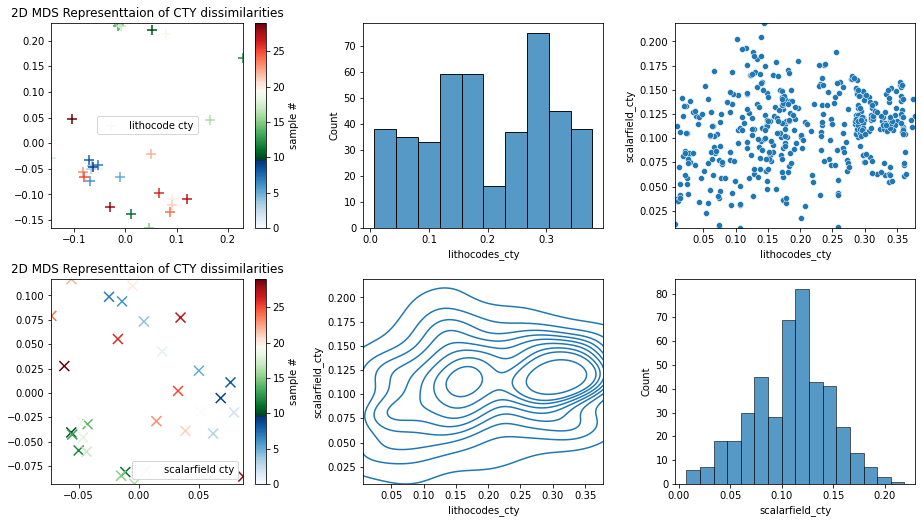

23-Aug-2022 (12:49:50) - COMPUTING 2D MDS REPRESENTATION END


In [11]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION START")
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

mdspos_lc = mds.fit(dist_cty_lc).embedding_
mdspos_sf = mds.fit(dist_cty_sf).embedding_

s_id = np.arange(nbsamples*3)
# Plot concentric circle dataset
colors1 = plt.cm.Blues(np.linspace(0., 1, 512))
colors2 = np.flipud(plt.cm.Greens(np.linspace(0, 1, 512)))
colors3 = plt.cm.Reds(np.linspace(0, 1, 512))
colors = np.vstack((colors1, colors2, colors3))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

ix=np.tril_indices(nbsamples*3,k=-1)
df= pd.DataFrame({'lithocodes_cty':dist_cty_lc[ix], 'scalarfield_cty':dist_cty_sf[ix]})

lcmin = np.amin(dist_cty_lc[ix]) 
lcmax = np.amax(dist_cty_lc[ix])
sfmin = np.amin(dist_cty_sf[ix]) 
sfmax = np.amax(dist_cty_sf[ix])

lcMDSxmin = np.min(mdspos_lc[:,0])
lcMDSxmax = np.max(mdspos_lc[:,0])
lcMDSymin = np.min(mdspos_lc[:,1])
lcMDSymax = np.max(mdspos_lc[:,1])

sfMDSxmin = np.min(mdspos_sf[:,0])
sfMDSxmax = np.max(mdspos_sf[:,0])
sfMDSymin = np.min(mdspos_sf[:,1])
sfMDSymax = np.max(mdspos_sf[:,1])

s = 100
fig = plt.figure()
plt.subplot(231)
plt.title('2D MDS Representtaion of CTY dissimilarities')
plt.scatter(mdspos_lc[:, 0], mdspos_lc[:, 1], c=s_id,cmap=mycmap, s=s, label='lithocode cty', marker='+')
plt.xlim(lcMDSxmin,lcMDSxmax)
plt.ylim(lcMDSymin,lcMDSymax)
plt.legend(scatterpoints=1, loc='best', shadow=False)
cbar = plt.colorbar()
cbar.set_label('sample #')
plt.subplot(234)
plt.title('2D MDS Representtaion of CTY dissimilarities')
plt.scatter(mdspos_sf[:, 0], mdspos_sf[:, 1], c=np.arange(nbsamples*3),cmap=mycmap, s=s, label='scalarfield cty', marker='x')
plt.xlim(sfMDSxmin,sfMDSxmax)
plt.ylim(sfMDSymin,sfMDSymax)
plt.legend(scatterpoints=1, loc='best', shadow=False)
cbar = plt.colorbar()
cbar.set_label('sample #')
plt.subplot(232)
sns.histplot(df.lithocodes_cty)
plt.subplot(233)
sns.scatterplot(x=df.lithocodes_cty,y=df.scalarfield_cty)
plt.xlim(lcmin,lcmax)
plt.ylim(sfmin,sfmax)
plt.subplot(235)
sns.kdeplot(x=df.lithocodes_cty,y=df.scalarfield_cty)
plt.xlim(lcmin,lcmax)
plt.ylim(sfmin,sfmax)
plt.subplot(236)
sns.histplot(df.scalarfield_cty)
fig.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.3, hspace=0.25)
plt.show()

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION END")

## Save indicators<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

In [12]:
with open(picklefilenameconnectivity, 'wb') as f:
    pickle.dump([dist_cty_lc,dist_cty_sf], f)